In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

DATABASE_FILEPATH = 'input.txt'

sequence_length = 100
BATCH_SIZE = 128
BUFFER_SIZE = 12000  # Elements are stored in a buffer of this size

embedding_dim = 256
rnn_units = 1280

LEARNING_RATE = 0.002
EPOCHS = 64

--2024-03-25 01:29:30--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-03-25 01:29:31 (45.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
# Load text from the input database
with open(DATABASE_FILEPATH, mode='r') as f:
  all_content = f.read()

print(f'{len(all_content)} characters loaded.')

# Find all the unique characters in the file
unique_chars = sorted(set(all_content))
vocabulary_size = len(unique_chars)

# Create index to vocabulary matching
char_to_idx = {ch:i for i,ch in enumerate(unique_chars)}
idx_to_char = np.array(unique_chars)

# Encode the input text for training
encoded_text = np.array([char_to_idx[char] for char in all_content])
examples_per_epoch = len(all_content) // (sequence_length + 1)

# Package the dataset into batches
character_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)
sequences = character_dataset.batch(sequence_length + 1, drop_remainder=True)

# Finalize the dataset
def chunk_data(chunk):
    input = chunk[:-1]
    target = chunk[1:]
    return input, target

dataset = sequences.map(chunk_data)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

1115394 characters loaded.


In [4]:
def build_model(vocabulary_size, embedding_dim, rnn_units, batch_size):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocabulary_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocabulary_size))

    return model

# Build the model
model = build_model(vocabulary_size, embedding_dim, rnn_units, BATCH_SIZE)

# Compile the model
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

# Handle directory management for checkpoints
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (128, None, 256)          16640     
                                                                 
 lstm (LSTM)                 (128, None, 1280)         7869440   
                                                                 
 dense (Dense)               (128, None, 65)           83265     
                                                                 
Total params: 7969345 (30.40 MB)
Trainable params: 7969345 (30.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# Train the model
training_record = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/64
86/86 [==============================] - 23s 77ms/step - loss: 3.0982
Epoch 2/64
86/86 [==============================] - 8s 67ms/step - loss: 2.2255
Epoch 3/64
86/86 [==============================] - 7s 63ms/step - loss: 1.9303
Epoch 4/64
86/86 [==============================] - 8s 65ms/step - loss: 1.7239
Epoch 5/64
86/86 [==============================] - 7s 65ms/step - loss: 1.5949
Epoch 6/64
86/86 [==============================] - 7s 63ms/step - loss: 1.5101
Epoch 7/64
86/86 [==============================] - 8s 65ms/step - loss: 1.4504
Epoch 8/64
86/86 [==============================] - 7s 64ms/step - loss: 1.4060
Epoch 9/64
86/86 [==============================] - 7s 65ms/step - loss: 1.3696
Epoch 10/64
86/86 [==============================] - 8s 64ms/step - loss: 1.3402
Epoch 11/64
86/86 [==============================] - 8s 67ms/step - loss: 1.3144
Epoch 12/64
86/86 [==============================] - 8s 66ms/step - loss: 1.2893
Epoch 13/64
86/86 [=================

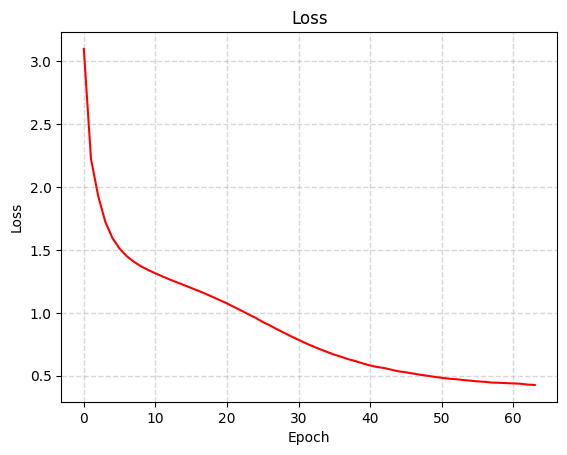

In [6]:
# Plot the loss graph
def render_training_record(training_record):
    loss = training_record.history['loss']
    plt.plot(loss, color='red')

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_record(training_record)

# Save the loss graph
loss_filename = f'{DATABASE_FILEPATH.split(".")[0]}_lr{LEARNING_RATE}' + \
                f'_units{rnn_units}.json'
with open(loss_filename, 'w') as f:
    json.dump(training_record.history, f)

In [7]:
LOAD_CHECKPOINT = None

In [8]:
# Rebuild the model for inference
inference_batch_size = 1

model = build_model(vocabulary_size, embedding_dim, rnn_units, batch_size=1)
if LOAD_CHECKPOINT is None:
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
else:
    specific_checkpoint = os.path.join(checkpoint_dir, f'ckpt_{LOAD_CHECKPOINT}')
    model.load_weights(specific_checkpoint)

model.build(tf.TensorShape([inference_batch_size, None]))

# Function for calling inference with the model
def generate_text(model, initial_chars, generate_length=1000, temperature=1.0):

    # Encode the initial string
    input_indices = [char_to_idx[s] for s in initial_chars]
    input_indices = tf.expand_dims(input_indices, 0)

    text_generated = []
    model.reset_states()

    for char_index in range(generate_length):

        predictions = model(input_indices)
        predictions = tf.squeeze(predictions, 0)  # Remove the extra dimension for batch
        predictions = predictions / temperature

        # Somewhat-randomly sample a following character from the model
        estimated_idx = tf.random.categorical(
          predictions,
          num_samples=1
        )[-1,0].numpy()

        # Now add the predicted character to the running input for the model
        input_indices = tf.expand_dims([estimated_idx], 0)

        text_generated.append(idx_to_char[estimated_idx])

    return (initial_chars + ''.join(text_generated))

In [9]:
print(generate_text(model, initial_chars=u"PORTIA:"))

PORTIA:
Then Warwick, thou art my warrior;
For I am rough at all that cares these bold ceasan:
The grey him that hath lived so sound
The accuser and the all-building
Where he done so wisely to all our heads.

HASTINGS:
I thank your grace;
Tell me what she studied, nor sea
What's 'But it clouds and there no less
Thy blood, my brother Grey, a blow of this.

HENRY BOLINGBROKE:
First, your emple, holy father:
Madam, yourselves are unnotard lucky
Whereoften had denied me to pry her joints as perforce.

MENENIUS:
I will tell you for she comes.
O honey on me; nay, speak mou lies:
I heard you have you dance. Probately then took the plants,
Yet to streap end.

MERCUTIO:
We to see the day; for this will out
My father with these all fort,
By cold ere I can confess it, and red with your sons,
To win the earth fall of Greece
Proclaim you to the people.

All:
Why look you patient for a king!
The loss of the man be which was
To take in me to swear a while.
This fear, I speak doth patience this?

CLIF

In [17]:
print(generate_text(model, initial_chars=u"ROMEO:", temperature=1.2))

ROMEO:
Then murders here Montague hath set you
A snockness of the keys; revenge their enmity
With charge: much we rest, in that hard-headed multitude to be ingrateful,
whereof thou shalt reign stole; I am resort; you do admit
you of these trier hath touch'd you to the field?
If no, my redresson: if you removed, his lifeit
And hated to, with a devil
The head, so far than I, it wrongs the contrary.
My lord, who washt on
'banished, have almost Rome, as they desire upon thee
To visit would retart: the devil he swear.

RICHARD:
I confess sent you so out of women's cloud,
By call'd you full as le.

FRIAR LAURENCE:
Now, by my headshe hand that stands
For when we stain haste, and thankful for,
embraces. What, farewell; I will; for had I be
rough it like your worship. This night you do wrong me your knowledge,
he would not need to push hastings: say you
have no brother, and I could have been so bright down,
And take our fear loud's the
ther.

AUTOLYCUS:
He hath help with me it is the rest;
And 